In [28]:
%matplotlib widget

In [1]:
%matplotlib inline

In [29]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from numba import njit
import scipy.interpolate
import scipy.optimize
import os
import lmfit
from tqdm import tqdm
import datetime

import fit_functions
import nekhoroshev_tools

In [30]:
OFFSET = (1.9508 - 0.8477) / 2
print(OFFSET)

#########################
# WARNING: THIS IS WRONG!
# OFFSET = -OFFSET
# print(OFFSET)
#########################

0.55155


In [31]:
def mm_to_sigma_horizontal(mm):
    return (mm - OFFSET) / (0.280)


def scale_factor(vals, sigma_barrier, scenario="3.2"):
    if scenario=="1":
        F = 1.5e-13
    if scenario=="2":
        m = -97e-15
        q = 5.8e-13
        F = m * sigma_barrier + q
    if scenario=="3.1":
        m = -82e-15
        q = 5.2e-13
        F = m * sigma_barrier + q
    if scenario=="3.2":
        m = -97e-15
        q = 6.2e-13
        F = m * sigma_barrier + q
    return vals / F


def get_roi(df, from_t, to_t):
    return df[(df["t"] >= from_t) & (df["t"] <= to_t)]

In [32]:
# read csv file
loss_1_rs9 = pd.read_csv("timber2/BLMEI.06L7.B1E10_TCP.A6L7.B1_LOSS_RS09.csv", header=1)
loss_1_rs6 = pd.read_csv("timber2/BLMEI.06L7.B1E10_TCP.A6L7.B1_LOSS_RS06.csv", header=1)
loss_1_rs4 = pd.read_csv("timber2/BLMEI.06L7.B1E10_TCP.A6L7.B1_LOSS_RS04.csv", header=1)
loss_2_rs9 = pd.read_csv("timber2/BLMTI.06L7.B1E10_TCP.D6L7.B1_LOSS_RS09.csv", header=1)
loss_2_rs6 = pd.read_csv("timber2/BLMTI.06L7.B1E10_TCP.D6L7.B1_LOSS_RS06.csv", header=1)
loss_2_rs4 = pd.read_csv("timber2/BLMTI.06L7.B1E10_TCP.D6L7.B1_LOSS_RS04.csv", header=1)

barrier = pd.read_csv("timber2/TCP.C6L7.B1_MEAS_LVDT_LU.csv", header=1)
barrier["Value"] = mm_to_sigma_horizontal(barrier["Value"])

In [33]:
# read csv file
loss_1_rs9 = pd.read_csv("timber/BLMTI.06L7.B1E10_TCP.C6L7.B1_LOSS_RS09.csv", header=1)
loss_1_rs6 = pd.read_csv("timber/BLMTI.06L7.B1E10_TCP.C6L7.B1_LOSS_RS06.csv", header=1)
loss_1_rs4 = pd.read_csv("timber/BLMTI.06L7.B1E10_TCP.C6L7.B1_LOSS_RS04.csv", header=1)
loss_2_rs9 = pd.read_csv("timber/BLMTI.06L7.B1E10_TCP.C6L7.B1_LOSS_RS09.csv", header=1)
loss_2_rs6 = pd.read_csv("timber/BLMTI.06L7.B1E10_TCP.C6L7.B1_LOSS_RS06.csv", header=1)
loss_2_rs4 = pd.read_csv("timber/BLMTI.06L7.B1E10_TCP.C6L7.B1_LOSS_RS04.csv", header=1)

barrier = pd.read_csv("timber2/TCP.C6L7.B1_MEAS_LVDT_LU.csv", header=1)
barrier["Value"] = mm_to_sigma_horizontal(barrier["Value"])

In [34]:
def utc_time_to_seconds(df):
    df["t"] = df["Timestamp (UTC_TIME)"].apply(
        lambda x: (
            datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f") - datetime.datetime.strptime(loss_1_rs9["Timestamp (UTC_TIME)"].iloc[0], "%Y-%m-%d %H:%M:%S.%f")).total_seconds()
    )
    return df

In [35]:
loss_1_rs9 = utc_time_to_seconds(loss_1_rs9)
loss_1_rs6 = utc_time_to_seconds(loss_1_rs6)
loss_1_rs4 = utc_time_to_seconds(loss_1_rs4)
loss_2_rs9 = utc_time_to_seconds(loss_2_rs9)
loss_2_rs6 = utc_time_to_seconds(loss_2_rs6)
loss_2_rs4 = utc_time_to_seconds(loss_2_rs4)

barrier = utc_time_to_seconds(barrier)

In [7]:
loss_1_rs9

,Timestamp (UTC_TIME),Value,t
0,2017-08-06 05:32:18.000,0.000014,0.0
1,2017-08-06 05:32:19.000,0.000010,1.0
2,2017-08-06 05:32:20.000,0.000007,2.0
3,2017-08-06 05:32:21.000,0.000006,3.0
4,2017-08-06 05:32:23.000,0.000005,5.0
...,...,...,...
64717,2017-08-07 00:10:31.000,0.000004,67093.0
64718,2017-08-07 00:11:31.000,0.000003,67153.0
64719,2017-08-07 00:12:31.000,0.000003,67213.0
64720,2017-08-07 00:13:31.000,0.000003,67273.0


(1.5, 10.5)

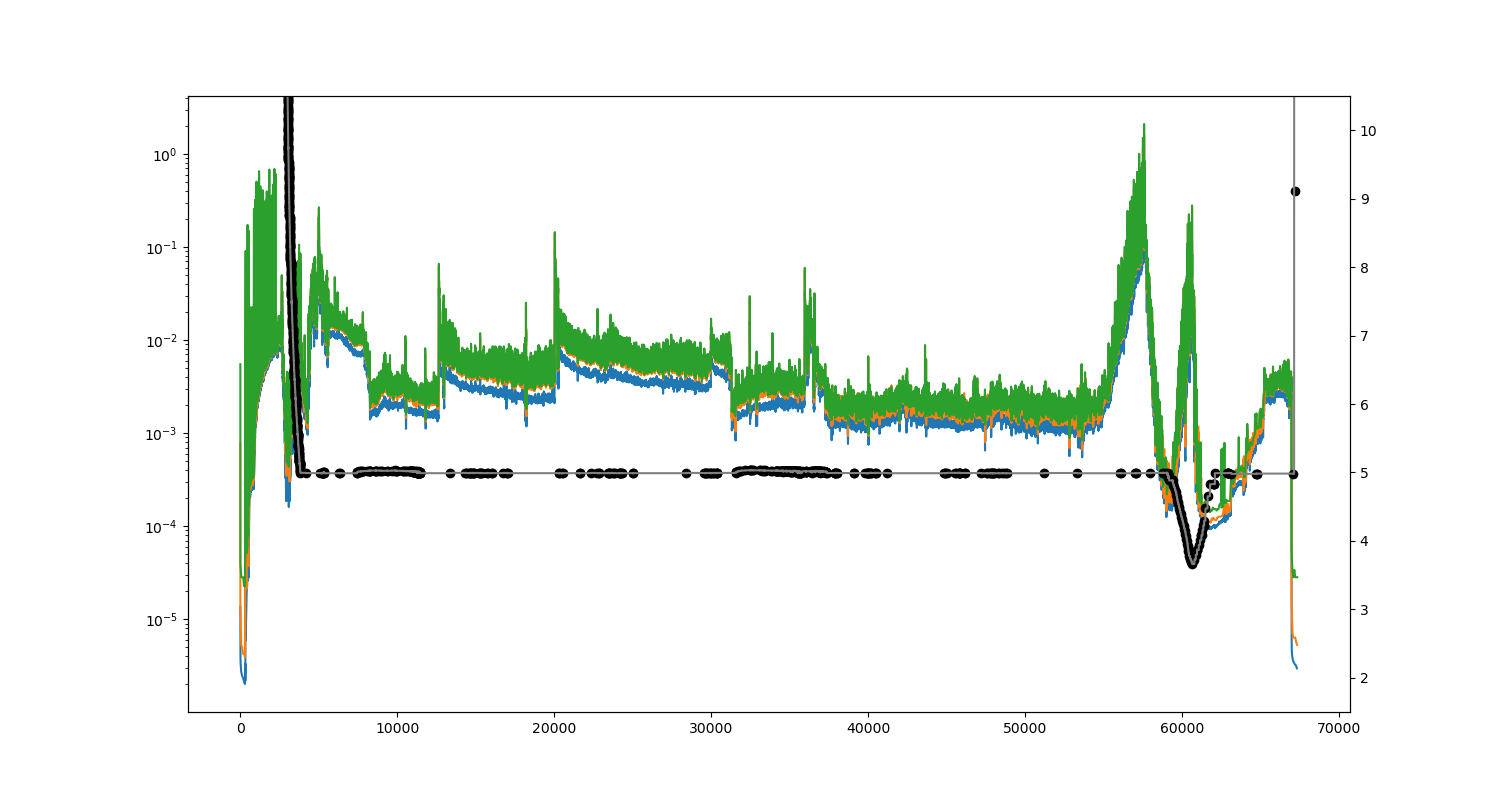

In [36]:
plt.figure(figsize=(15, 8))

plt.plot(loss_1_rs9["t"], loss_1_rs9["Value"], label="RS9")
plt.plot(loss_1_rs6["t"], loss_1_rs6["Value"], label="RS6")
plt.plot(loss_1_rs4["t"], loss_1_rs4["Value"], label="RS4")

plt.yscale("log")

plt.twinx()
plt.scatter(barrier["t"], barrier["Value"], label="Barrier", color="black")

b_func = scipy.interpolate.interp1d(
    barrier["t"], barrier["Value"], kind="previous", fill_value="extrapolate"
)
plt.plot(loss_1_rs9["t"], b_func(loss_1_rs9["t"]), label="Barrier", color="grey")

plt.ylim(1.5, 10.5)

(1.5, 10.5)

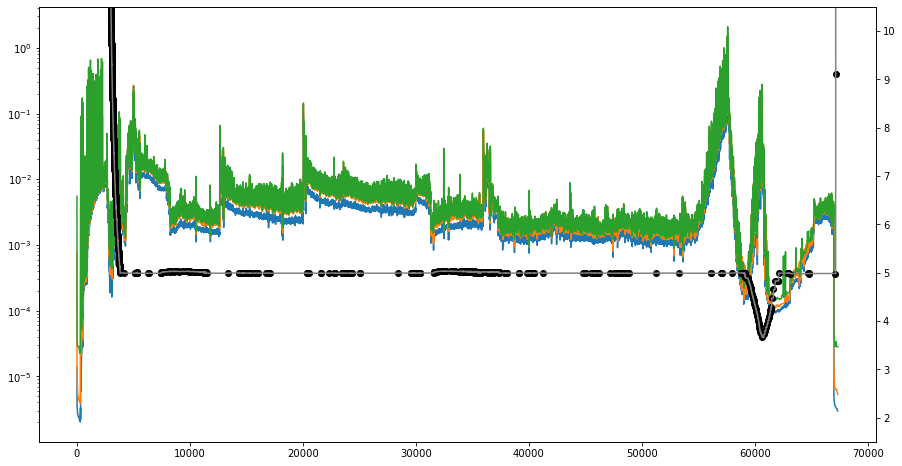

In [8]:
plt.figure(figsize=(15, 8))

plt.plot(loss_2_rs9["t"], loss_2_rs9["Value"], label="RS9")
plt.plot(loss_2_rs6["t"], loss_2_rs6["Value"], label="RS6")
plt.plot(loss_2_rs4["t"], loss_2_rs4["Value"], label="RS4")

plt.yscale("log")

plt.twinx()
plt.scatter(barrier["t"], barrier["Value"], label="Barrier", color="black")

b_func = scipy.interpolate.interp1d(
    barrier["t"], barrier["Value"], kind="previous", fill_value="extrapolate"
)
plt.plot(loss_1_rs9["t"], b_func(loss_1_rs9["t"]), label="Barrier", color="grey")

plt.ylim(1.5, 10.5)

In [9]:
from_t = 60648.0
to_t = 61300.0

In [10]:
loss_1_rs4 = get_roi(loss_1_rs4, from_t, to_t)
loss_1_rs6 = get_roi(loss_1_rs6, from_t, to_t)
loss_1_rs9 = get_roi(loss_1_rs9, from_t, to_t)
loss_2_rs4 = get_roi(loss_2_rs4, from_t, to_t)
loss_2_rs6 = get_roi(loss_2_rs6, from_t, to_t)
loss_2_rs9 = get_roi(loss_2_rs9, from_t, to_t)

barrier = get_roi(barrier, from_t, to_t)

(3.5, 5.5)

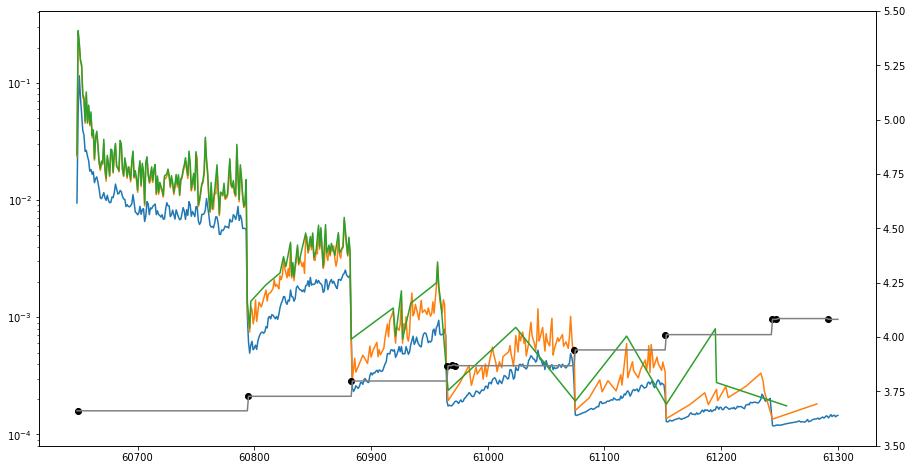

In [11]:
plt.figure(figsize=(15, 8))

plt.plot(loss_1_rs9["t"], loss_1_rs9["Value"], label="RS9")
plt.plot(loss_1_rs6["t"], loss_1_rs6["Value"], label="RS6")
plt.plot(loss_1_rs4["t"], loss_1_rs4["Value"], label="RS4")

plt.yscale("log")

plt.twinx()
plt.scatter(barrier["t"], barrier["Value"], label="Barrier", color="black")

b_func = scipy.interpolate.interp1d(
    barrier["t"], barrier["Value"], kind="previous", fill_value="extrapolate"
)
plt.plot(loss_1_rs9["t"], b_func(loss_1_rs9["t"]), label="Barrier", color="grey")

plt.ylim(3.5, 5.5)

In [12]:
b_func = scipy.interpolate.interp1d(
    barrier["t"], barrier["Value"], kind="previous", fill_value="extrapolate"
)

def get_idx_vals(df):
    diffs = np.diff(b_func(df["t"]))
    idxs = np.where(diffs > 0.005)[0]
    vals = loss_1_rs9["t"].iloc[np.where(diffs > 0.01)]
    return idxs, vals

In [13]:
idx_loss_1_rs9, vals_loss_1_rs9 = get_idx_vals(loss_1_rs9)
idx_loss_1_rs6, vals_loss_1_rs6 = get_idx_vals(loss_1_rs6)
idx_loss_1_rs4, vals_loss_1_rs4 = get_idx_vals(loss_1_rs4)
idx_loss_2_rs9, vals_loss_2_rs9 = get_idx_vals(loss_2_rs9)
idx_loss_2_rs6, vals_loss_2_rs6 = get_idx_vals(loss_2_rs6)
idx_loss_2_rs4, vals_loss_2_rs4 = get_idx_vals(loss_2_rs4)

(3.5, 5.5)

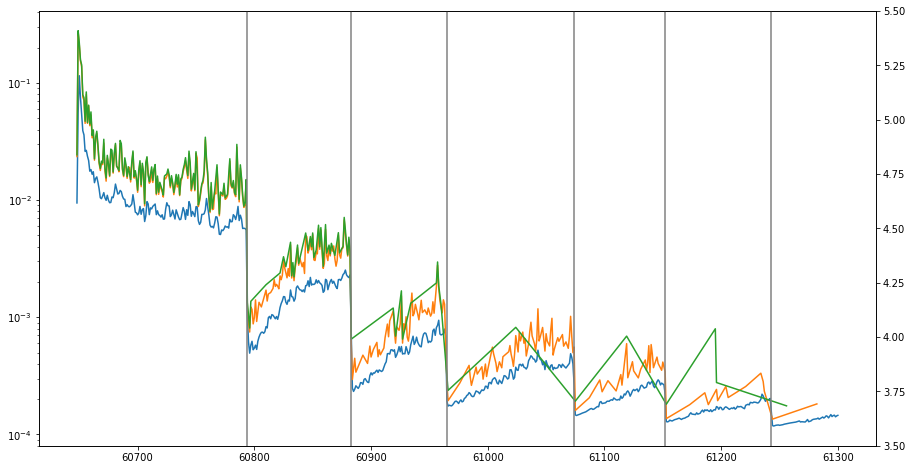

In [15]:
plt.figure(figsize=(15, 8))

plt.plot(loss_1_rs9["t"], loss_1_rs9["Value"], label="RS9")
plt.plot(loss_1_rs6["t"], loss_1_rs6["Value"], label="RS6")
plt.plot(loss_1_rs4["t"], loss_1_rs4["Value"], label="RS4")

plt.yscale("log")

plt.twinx()
plt.scatter(barrier["t"], barrier["Value"], label="Barrier", color="black")

b_func = scipy.interpolate.interp1d(
    barrier["t"], barrier["Value"], kind="previous", fill_value="extrapolate"
)
plt.plot(loss_1_rs9["t"], b_func(loss_1_rs9["t"]), label="Barrier", color="grey")

for v in vals_loss_1_rs9:
    plt.axvline(v, color="grey")

plt.ylim(3.5, 5.5)

In [14]:
def get_slices(df, vals, idxs):
    slices = []

    for i in range(len(vals) - 1):
        slices.append((
            df["t"].iloc[idxs[i]: idxs[i+1]].values,
            df["Value"].iloc[idxs[i]: idxs[i+1]].values,
            np.mean(b_func(df["t"].iloc[idxs[i]+1: idxs[i+1]-1].values)),
            (idxs[i], idxs[i+1])
        ))
    return slices

In [15]:
def reset_indexes(df, slices, idxs, slice_val=5):
    new_slices = []
    for i, s in enumerate(slices[:]):
        if i == 0:
            new_left = np.argmin(s[1][:slice_val]) + s[3][0]
        else:
            data = np.concatenate((
                slices[i-1][1][-slice_val:],
                slices[i][1][:slice_val]
            ))
            rel_index = np.argmin(data)
            if rel_index < slice_val:
                new_left = slices[i-1][3][1] + rel_index
            else:
                new_left = slices[i][3][0] + rel_index - slice_val
        
        if i == len(slices) - 1:
            new_right = np.argmax(s[1][-slice_val:]) + s[3][1] - slice_val
        else:
            data = np.concatenate((
                slices[i][1][-slice_val:],
                slices[i+1][1][:slice_val]
            ))
            rel_index = np.argmax(data)
            if rel_index < slice_val:
                new_right = slices[i][3][1] + rel_index - slice_val
            else:
                new_right = slices[i+1][3][0] + rel_index - slice_val

        new_slices.append((
            df["t"].values[new_left: new_right],
            df["Value"].values[new_left: new_right],
            np.mean(b_func(df["t"].values[idxs[i]+1: idxs[i+1]-1])),
            (new_left, new_right)
        ))
    return new_slices

In [31]:
loss_1_rs9["t"].values

array([60648., 60649., 60650., 60651., 60652., 60653., 60654., 60655.,
       60656., 60657., 60658., 60659., 60660., 60661., 60662., 60663.,
       60664., 60665., 60666., 60667., 60668., 60669., 60670., 60671.,
       60672., 60673., 60674., 60675., 60676., 60677., 60678., 60679.,
       60680., 60681., 60682., 60683., 60684., 60685., 60686., 60687.,
       60688., 60689., 60690., 60691., 60692., 60693., 60694., 60695.,
       60696., 60697., 60698., 60699., 60700., 60701., 60702., 60703.,
       60704., 60705., 60706., 60707., 60708., 60709., 60710., 60711.,
       60712., 60713., 60714., 60715., 60716., 60717., 60718., 60719.,
       60720., 60721., 60722., 60723., 60724., 60725., 60726., 60727.,
       60728., 60729., 60730., 60731., 60732., 60733., 60734., 60735.,
       60736., 60737., 60738., 60739., 60740., 60741., 60742., 60743.,
       60744., 60745., 60746., 60747., 60748., 60749., 60750., 60751.,
       60752., 60753., 60754., 60755., 60756., 60757., 60758., 60759.,
      

In [16]:
slice_loss_1_rs9 = reset_indexes(loss_1_rs9, get_slices(loss_1_rs9, vals_loss_1_rs9, idx_loss_1_rs9), idx_loss_1_rs9)
slice_loss_1_rs6 = reset_indexes(loss_1_rs6, get_slices(loss_1_rs6, vals_loss_1_rs6, idx_loss_1_rs6), idx_loss_1_rs6)
slice_loss_1_rs4 = reset_indexes(loss_1_rs4, get_slices(loss_1_rs4, vals_loss_1_rs4, idx_loss_1_rs4), idx_loss_1_rs4)
slice_loss_2_rs4 = reset_indexes(loss_2_rs4, get_slices(loss_2_rs4, vals_loss_2_rs4, idx_loss_2_rs4), idx_loss_2_rs4)
slice_loss_2_rs6 = reset_indexes(loss_2_rs6, get_slices(loss_2_rs6, vals_loss_2_rs6, idx_loss_2_rs6), idx_loss_2_rs6)
slice_loss_2_rs9 = reset_indexes(loss_2_rs9, get_slices(loss_2_rs9, vals_loss_2_rs9, idx_loss_2_rs9), idx_loss_2_rs9)

/home/HPC/camontan/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/HPC/camontan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [17]:
def add_scale_factor(slices, scenario="3.2"):
    new_slices = []
    for i, s in enumerate(slices):
        new_slices.append((s[0], scale_factor(s[1], s[2], scenario=scenario), s[2], s[3]))
    return new_slices

In [18]:
slice_loss_1_rs9 = add_scale_factor(slice_loss_1_rs9)
slice_loss_1_rs6 = add_scale_factor(slice_loss_1_rs6)
slice_loss_1_rs4 = add_scale_factor(slice_loss_1_rs4)
slice_loss_2_rs4 = add_scale_factor(slice_loss_2_rs4)
slice_loss_2_rs6 = add_scale_factor(slice_loss_2_rs6)
slice_loss_2_rs9 = add_scale_factor(slice_loss_2_rs9)

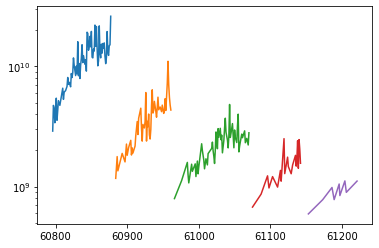

In [19]:
plt.figure()
for s in slice_loss_1_rs6:
    plt.plot(s[0], s[1])

plt.yscale("log")

In [20]:
slice_loss_2_rs6[0]

(array([60796., 60810., 60822., 60828., 60831., 60832., 60836., 60837.,
        60838., 60844., 60846., 60848., 60849., 60850., 60851., 60853.,
        60855., 60856., 60857., 60858., 60859., 60861., 60862., 60864.,
        60865., 60866., 60869., 60872., 60873., 60876., 60877.]),
 array([9.2270e-05, 1.5661e-04, 2.3721e-04, 1.9408e-04, 3.5776e-04,
        1.8984e-04, 2.4357e-04, 3.2099e-04, 2.2837e-04, 3.9594e-04,
        2.8705e-04, 3.6059e-04, 3.0650e-04, 4.0584e-04, 2.4534e-04,
        2.9448e-04, 4.7831e-04, 3.0261e-04, 4.6381e-04, 3.0721e-04,
        2.0822e-04, 4.6275e-04, 2.7115e-04, 3.1746e-04, 2.6372e-04,
        3.2029e-04, 2.5701e-04, 4.0725e-04, 2.7680e-04, 3.2523e-04,
        5.4441e-04]),
 7.461332536400585,
 (136, 167))

In [20]:
def get_spline(slices):
    x = []
    y = []
    for s in slices:
        try:
            x.append(s[0][-1])
            y.append(s[1][-1])
        except:
            pass
    spline = scipy.interpolate.UnivariateSpline(
    np.asarray(x), np.log10(y), k=2, s=1) 

    return lambda x: np.power(10, spline(x))

In [21]:
#spline_loss_1_rs9 = get_spline(slice_loss_1_rs9)
spline_loss_1_rs6 = get_spline(slice_loss_1_rs6)
# spline_loss_1_rs4 = get_spline(slice_loss_1_rs4)
# spline_loss_2_rs4 = get_spline(slice_loss_2_rs4)
# spline_loss_2_rs6 = get_spline(slice_loss_2_rs6)
# spline_loss_2_rs9 = get_spline(slice_loss_2_rs9)

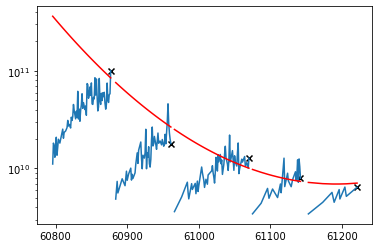

In [40]:
plt.figure()
for s in slice_loss_1_rs6:
    plt.plot(s[0], s[1], color="C0")
    plt.scatter([s[0][-1]], [s[1][-1]], color="black", marker="x")
    plt.plot(s[0], spline_loss_1_rs6(s[0]), color="red")

plt.yscale("log")

In [22]:
def compose_fit_lists(slices, spline, samples_per_slice=25, spline_multiplier=1.0):
    x_raw = []
    all_raw = []
    x_list = []
    y_list = []

    for i in range(1, len(slices)):
        try:
            from_value = slices[i-1][2]
            to_value = slices[i][2]
            times = slices[i][0] - slices[i][0][0] 
            times[0] += times[1] * 0.2 # so that it's not zero
            the_function = spline(slices[i][0]) * spline_multiplier
            values = slices[i][1] / the_function
            
            # x_raw.append(slices[i][0])
            # y_raw.append(values)

            if len(values) < samples_per_slice + 1:
                idxs = np.arange(1, len(values))
            else:
                idxs = np.linspace(1, len(values), samples_per_slice, dtype=int, endpoint=False)
            all_raw.append((slices[i][0], values-1))
            
            values = values[idxs]
            times = times[idxs]

            x_raw.append(slices[i][0][idxs])

            x_list.append(("forward", from_value, to_value, times))
            y_list.append(values-1)
        except:
            pass    
    return x_raw, all_raw, x_list, y_list

In [24]:
x_raw, y_raw, x_list, y_list = compose_fit_lists(slice_loss_1_rs6, spline_loss_1_rs6)

In [23]:
# _, _, x_list_loss_1_rs9, y_list_loss_1_rs9 = compose_fit_lists(slice_loss_1_rs9, spline_loss_1_rs9)
x_raw_loss_1_rs6, all_raw_loss_1_rs6, x_list_loss_1_rs6, y_list_loss_1_rs6 = compose_fit_lists(slice_loss_1_rs6, spline_loss_1_rs6)
# _, _, x_list_loss_1_rs4, y_list_loss_1_rs4 = compose_fit_lists(slice_loss_1_rs4, spline_loss_1_rs4)

# _, _, x_list_loss_2_rs4, y_list_loss_2_rs4 = compose_fit_lists(slice_loss_2_rs4, spline_loss_2_rs4)
# _, _, x_list_loss_2_rs6, y_list_loss_2_rs6 = compose_fit_lists(slice_loss_2_rs6, spline_loss_2_rs6)
# _, _, x_list_loss_2_rs9, y_list_loss_2_rs9 = compose_fit_lists(slice_loss_2_rs9, spline_loss_2_rs9)


In [24]:
x_raw_loss_1_rs6_mult_1_25, all_raw_loss_1_rs6_mult_1_25, x_list_loss_1_rs6_mult_1_25, y_list_loss_1_rs6_mult_1_25 = compose_fit_lists(slice_loss_1_rs6, spline_loss_1_rs6, spline_multiplier=1.25)

In [25]:
x_raw_loss_1_rs6_mult_1_5, all_raw_loss_1_rs6_mult_1_5, x_list_loss_1_rs6_mult_1_5, y_list_loss_1_rs6_mult_1_5 = compose_fit_lists(slice_loss_1_rs6, spline_loss_1_rs6, spline_multiplier=1.5)

In [26]:
x_raw_loss_1_rs6_mult_2_0, all_raw_loss_1_rs6_mult_2_0, x_list_loss_1_rs6_mult_2_0, y_list_loss_1_rs6_mult_2_0 = compose_fit_lists(slice_loss_1_rs6, spline_loss_1_rs6, spline_multiplier=2.0)

In [27]:
with open("to_fit_b1_h.pkl", "wb") as f:
    pickle.dump(
        {
            # "loss_1_rs9": (x_list_loss_1_rs9, y_list_loss_1_rs9),
            "loss_1_rs6": (x_list_loss_1_rs6, y_list_loss_1_rs6),
            "loss_1_rs6_mult_1_25": (x_list_loss_1_rs6_mult_1_25, y_list_loss_1_rs6_mult_1_25),
            "loss_1_rs6_mult_1_5": (x_list_loss_1_rs6_mult_1_5, y_list_loss_1_rs6_mult_1_5),
            "loss_1_rs6_mult_2_0": (x_list_loss_1_rs6_mult_2_0, y_list_loss_1_rs6_mult_2_0),
            # "loss_1_rs4": (x_list_loss_1_rs4, y_list_loss_1_rs4),
            # "loss_2_rs4": (x_list_loss_2_rs4, y_list_loss_2_rs4),
            # "loss_2_rs6": (x_list_loss_2_rs6, y_list_loss_2_rs6),
            # "loss_2_rs9": (x_list_loss_2_rs9, y_list_loss_2_rs9),
        }
        ,f
    )

In [29]:
fit_result = {}
# for key in ["loss_1_rs6", "loss_1_rs6_mult_1_25", "loss_1_rs6_mult_1_5", "loss_1_rs6_mult_2_0", "loss_2_rs6", "loss_2_rs6_mult_1_25", "loss_2_rs6_mult_1_5", "loss_2_rs6_mult_2_0"]:
for key in ["loss_1_rs6", "loss_1_rs6_mult_1_25", "loss_1_rs6_mult_1_5", "loss_1_rs6_mult_2_0"]:
    with open(f"fit_result_b1_v_{key}_single_kmax_2.1.pkl", "rb") as f:
        fit_result[key] = pickle.load(f)

In [30]:
fit_result["loss_1_rs6"][0]

In [31]:
fit_result["loss_1_rs6_mult_1_25"][0]

In [32]:
fit_result["loss_1_rs6_mult_1_5"][0]

In [33]:
fit_result["loss_1_rs6_mult_2_0"][0]

In [118]:
fit_result = {}
for key in ["loss_1_rs6"]:
    with open(f"fit_result_b1_h_{key}_single_kmax_2.1.pkl", "rb") as f:
        fit_result[key] = pickle.load(f)

In [119]:
fit_result["loss_1_rs6"][0]

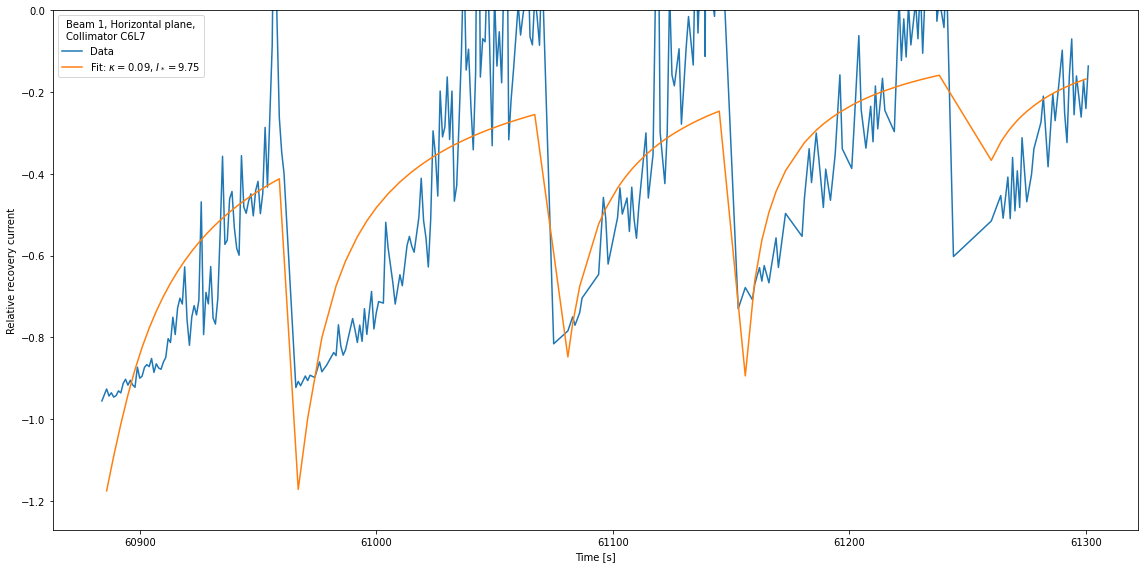

In [121]:
plt.figure(figsize=(16,8))

tmp_times = np.array([])
tmp_x = np.array([])
tmp_y = np.array([])

for x in x_raw_loss_1_rs6:
    tmp_times = np.append(tmp_times, x)

for data in all_raw_loss_1_rs6:
    tmp_x = np.append(tmp_x, data[0])
    tmp_y = np.append(tmp_y, data[1])

plt.plot(tmp_x, tmp_y, label="Data")
plt.plot(tmp_times, fit_result["loss_1_rs6"][2][:], label=f"Fit: $\\kappa = {fit_result['loss_1_rs6'][0].params['k'].value:.2f}$, $I_*={fit_result['loss_1_rs6'][0].params['I_star'].value:.2f}$")

plt.ylim(top=0.0)
plt.xlabel("Time [s]")
plt.ylabel("Relative recovery current")

plt.legend(title="Beam 1, Horizontal plane,\nCollimator C6L7")

plt.tight_layout()
plt.savefig("figs/b1_h_fit_single_kmax_2.1.jpg", dpi=300)

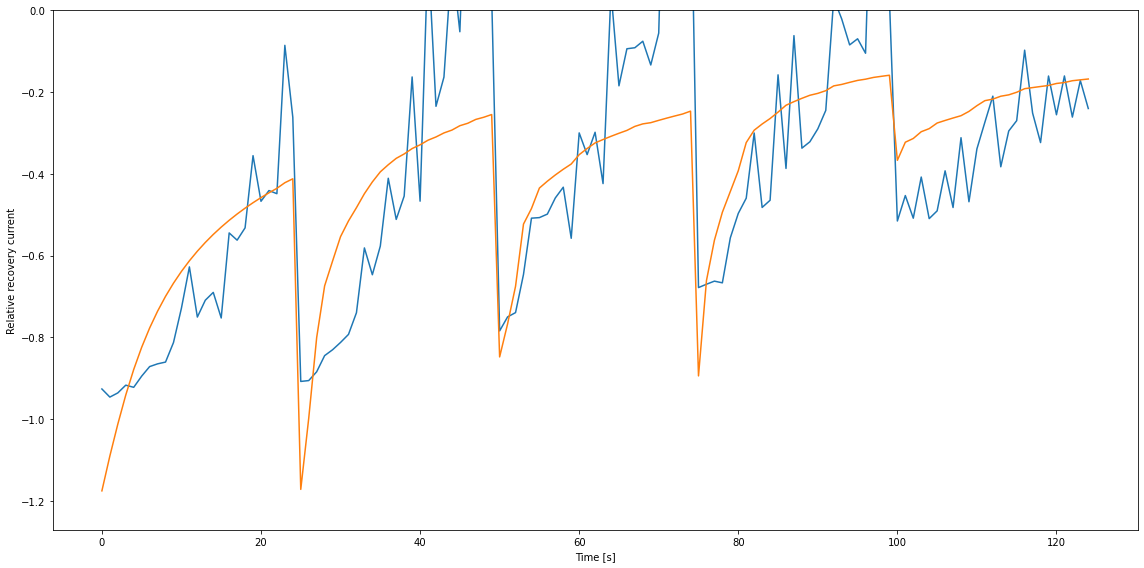

In [112]:
plt.figure(figsize=(16,8))
plt.plot(fit_result["loss_1_rs6"][1])
plt.plot(fit_result["loss_1_rs6"][2])

plt.ylim(top=0.0)
plt.xlabel("Time [s]")
plt.ylabel("Relative recovery current")
plt.tight_layout()

In [65]:
fit_result = {}
for key in ["loss_1_rs9", "loss_1_rs6", "loss_1_rs4", "loss_2_rs4", "loss_2_rs6", "loss_2_rs9"]:
    with open(f"fit_result_{key}_single_kmax_2.0.pkl", "rb") as f:
        fit_result[key] = pickle.load(f)
    

In [ ]:
fit_result = {}
for key in ["loss_2_rs6"]:
    with open(f"fit_result_b2_h_{key}_single_kmax_2.1.pkl", "rb") as f:
        fit_result[key] = pickle.load(f)

In [ ]:
fit_result["loss_2_rs6"][0]

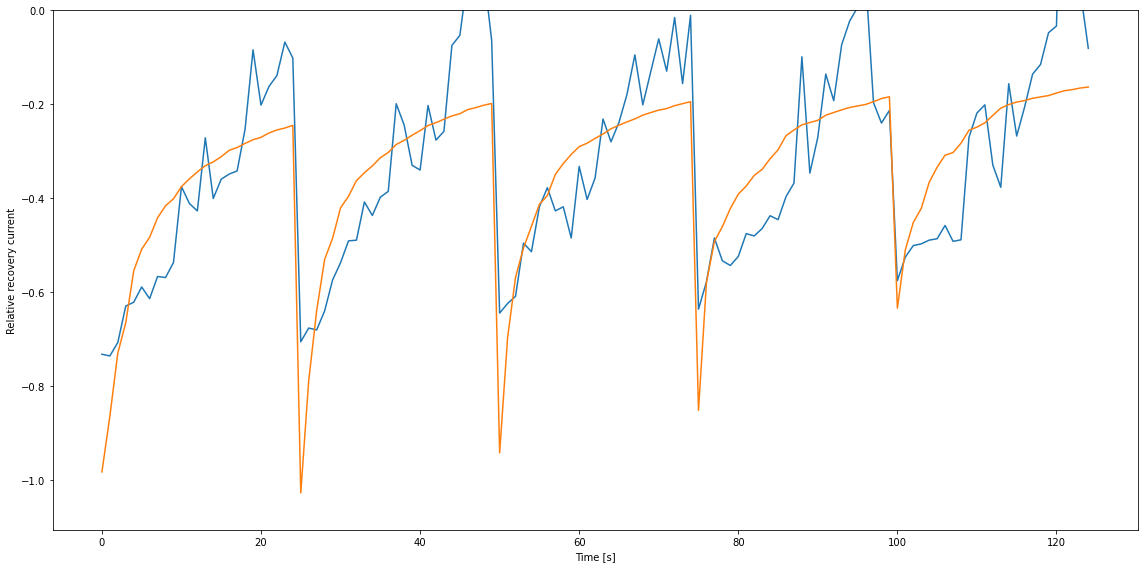

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(fit_result["loss_2_rs6"][1])
plt.plot(fit_result["loss_2_rs6"][2])

plt.ylim(top=0.0)
plt.xlabel("Time [s]")
plt.ylabel("Relative recovery current")
plt.tight_layout()

In [80]:
pars = lmfit.Parameters()
pars.add("I_star", value=10.0, min=0.0)
pars.add("k", value=0.33, min=0.0)
pars.add("c", value=1.0, vary=False)

In [81]:
fit_c1, fit_c2 = fit_functions.ana_current(pars, x_list_loss_1_rs6, y_list_loss_1_rs6)

Values: I_star 10.0 k 0.33


In [29]:
x_list_loss_1_rs6[0][-1][0]

0.01

20.743337651704664


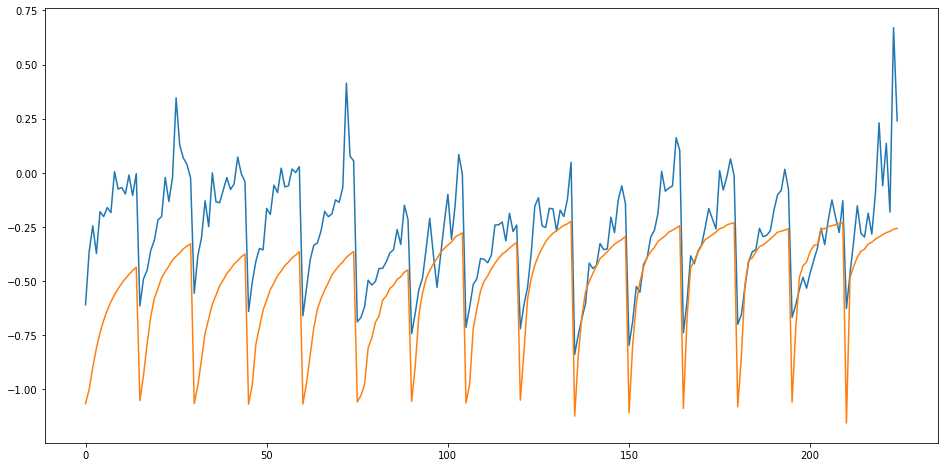

In [82]:
plt.figure(figsize=(16,8))

plt.plot(fit_c1)
plt.plot(fit_c2)
print(np.sum(((fit_c1 - fit_c2))**2))

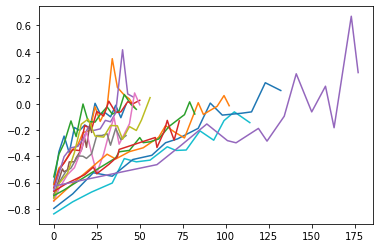

In [31]:
for x, y in zip(x_list_loss_1_rs6, y_list_loss_1_rs6):
    plt.plot(x[-1], y)

In [83]:
fit_result = lmfit.minimize(
    fit_functions.resid_func, pars, args=(x_list_loss_1_rs6, y_list_loss_1_rs6)
)
fit_c1, fit_c2 = fit_functions.ana_current(fit_result.params, x_list_loss_1_rs6, y_list_loss_1_rs6)

Values: I_star 10.0 k 0.33000000000000007 c 1.0
Error: 20.743337651704632
Values: I_star 10.0 k 0.33000000000000007 c 1.0
Error: 20.743337651704632
Values: I_star 10.0 k 0.33000000000000007 c 1.0
Error: 20.743337651704632
Values: I_star 10.000000162558123 k 0.33000000000000007 c 1.0
Error: 20.743341720996845
Values: I_star 10.0 k 0.33000000861466394 c 1.0
Error: 20.743331371060258
Values: I_star 13.762537971014638 k 0.507442331649876 c 1.0
Error: 7.507679848728185
Values: I_star 13.762538189984205 k 0.507442331649876 c 1.0
Error: 7.5076799335256945
Values: I_star 13.762537971014638 k 0.5074423442274547 c 1.0
Error: 7.507679662341905
Values: I_star 21.383600382087707 k 0.75301240791366 c 1.0
Error: 8.137343757271452
Values: I_star 15.84155429712024 k 0.5773098257876528 c 1.0
Error: 7.392987225094325
Values: I_star 15.841554547194168 k 0.5773098257876528 c 1.0
Error: 7.392987184785907
Values: I_star 15.84155429712024 k 0.5773098398442009 c 1.0
Error: 7.392987298521351
Values: I_star 20.4

7.307434574659089


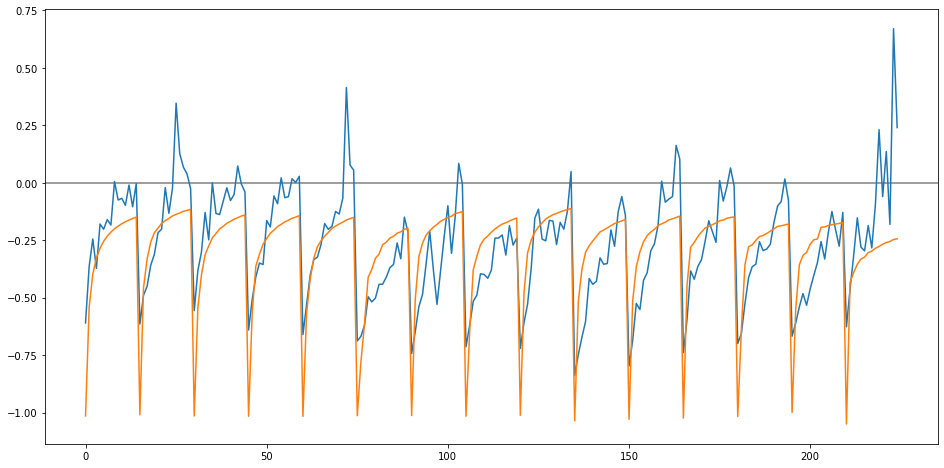

In [89]:
plt.figure(figsize=(16,8))

plt.axhline(0.0, color="grey")

plt.plot(fit_c1)
plt.plot(fit_c2)

print(np.sum(((fit_c1 - fit_c2))**2))

In [66]:
fit_result["loss_1_rs9"][0]

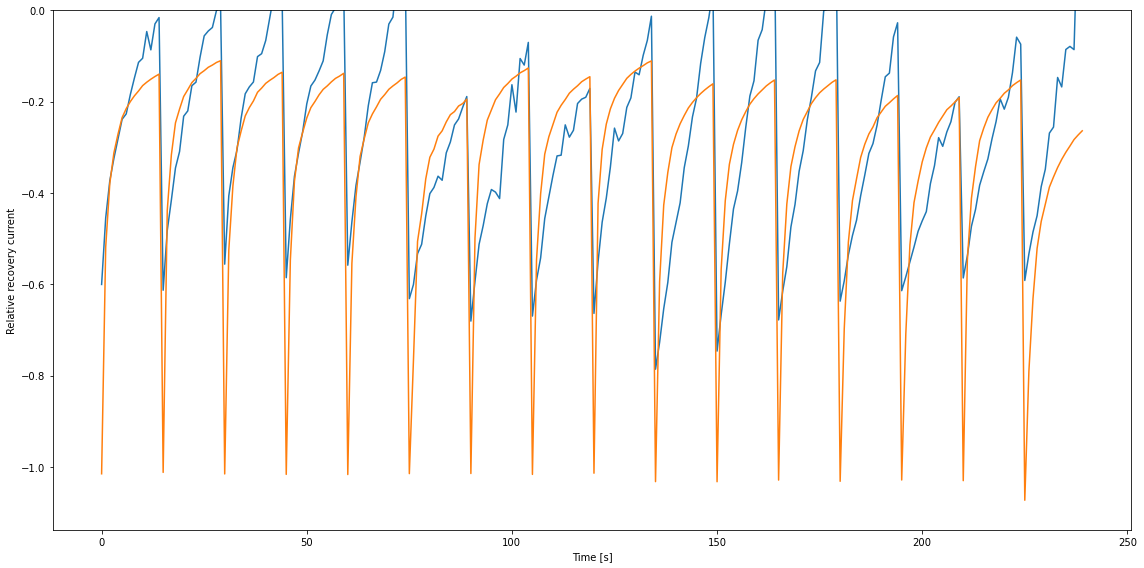

In [67]:
plt.figure(figsize=(16,8))
plt.plot(fit_result["loss_1_rs9"][1])
plt.plot(fit_result["loss_1_rs9"][2])

plt.ylim(top=0.0)
plt.xlabel("Time [s]")
plt.ylabel("Relative recovery current")
plt.tight_layout()

In [68]:
fit_result["loss_1_rs6"][0]

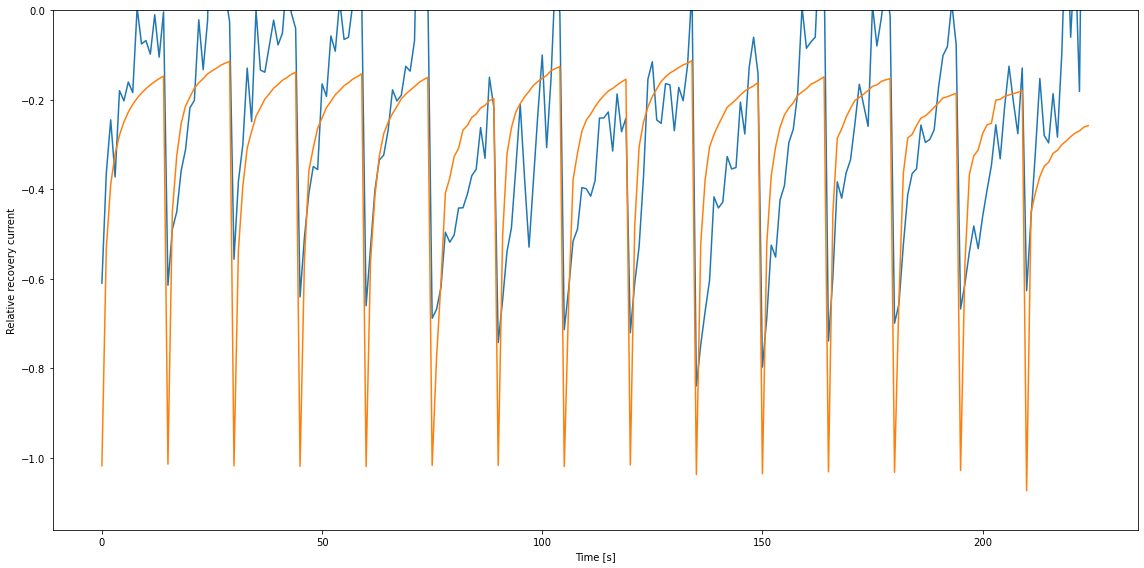

In [69]:
plt.figure(figsize=(16,8))
plt.plot(fit_result["loss_1_rs6"][1])
plt.plot(fit_result["loss_1_rs6"][2])


plt.ylim(top=0.0)
plt.xlabel("Time [s]")
plt.ylabel("Relative recovery current")
plt.tight_layout()

In [70]:
fit_result["loss_1_rs4"][0]

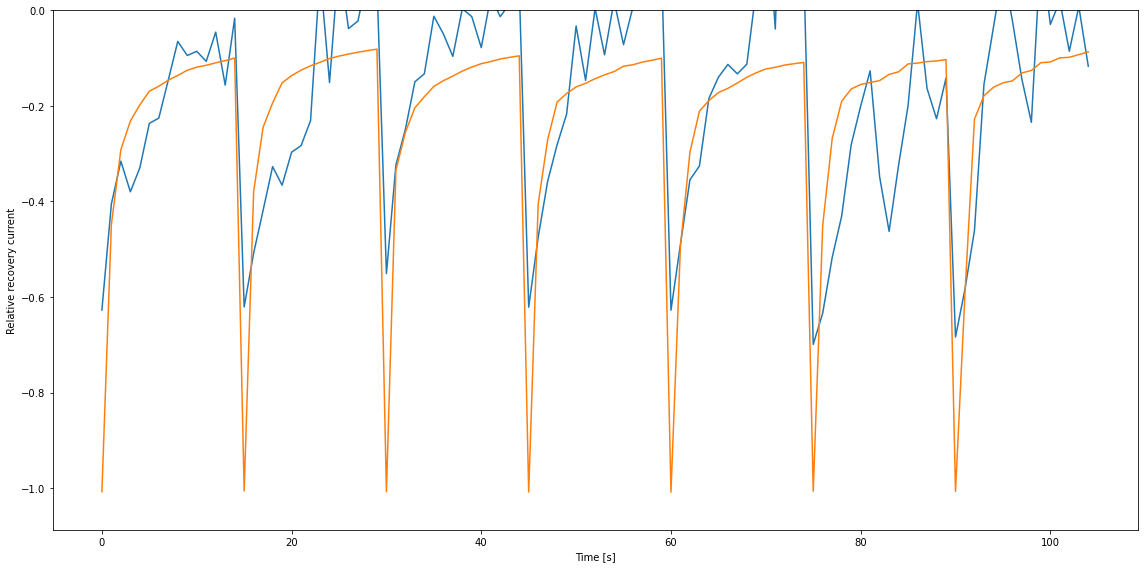

In [71]:
plt.figure(figsize=(16,8))
plt.plot(fit_result["loss_1_rs4"][1])
plt.plot(fit_result["loss_1_rs4"][2])

plt.ylim(top=0.0)
plt.xlabel("Time [s]")
plt.ylabel("Relative recovery current")
plt.tight_layout()

In [72]:
fit_result["loss_2_rs9"][0]

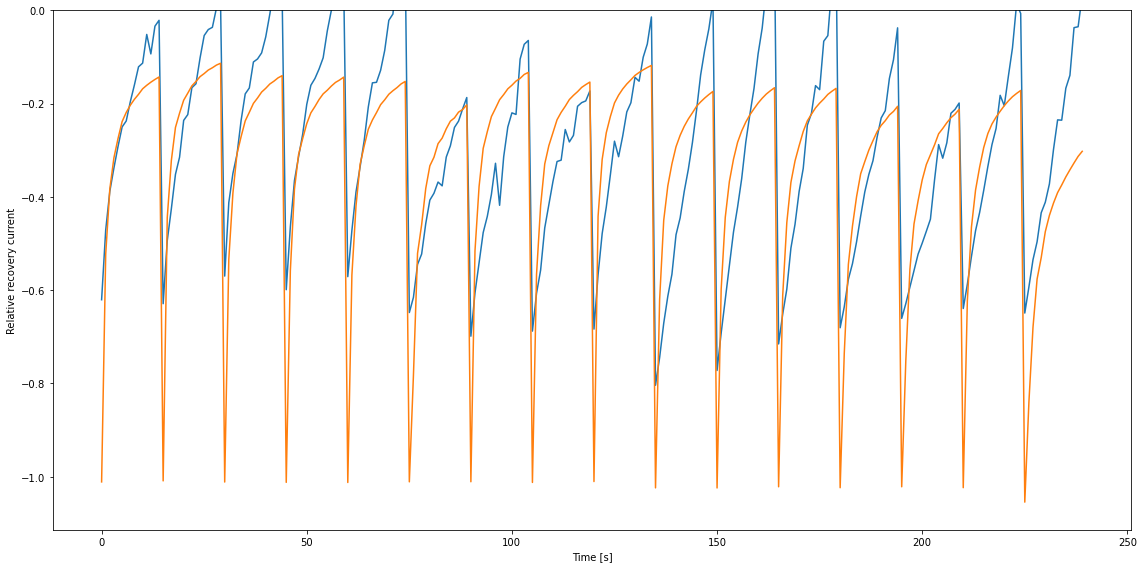

In [73]:
plt.figure(figsize=(16,8))
plt.plot(fit_result["loss_2_rs9"][1])
plt.plot(fit_result["loss_2_rs9"][2])

plt.ylim(top=0.0)
plt.xlabel("Time [s]")
plt.ylabel("Relative recovery current")
plt.tight_layout()

In [74]:
fit_result["loss_2_rs6"][0]

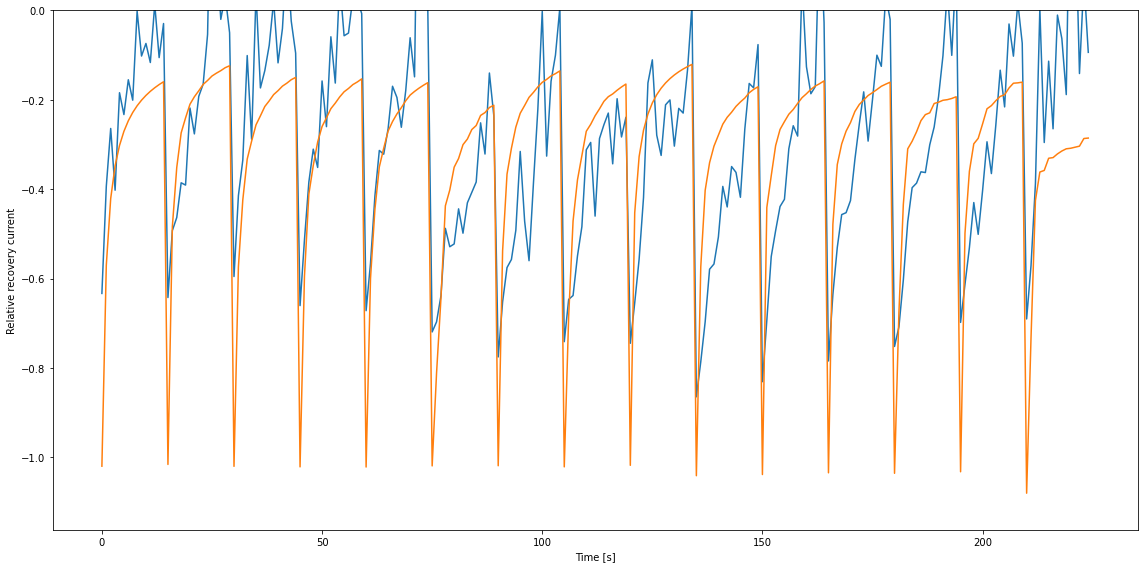

In [75]:
plt.figure(figsize=(16,8))
plt.plot(fit_result["loss_2_rs6"][1])
plt.plot(fit_result["loss_2_rs6"][2])
plt.ylim(top=0.0)
plt.xlabel("Time [s]")
plt.ylabel("Relative recovery current")
plt.tight_layout()

In [76]:
fit_result["loss_2_rs4"][0]

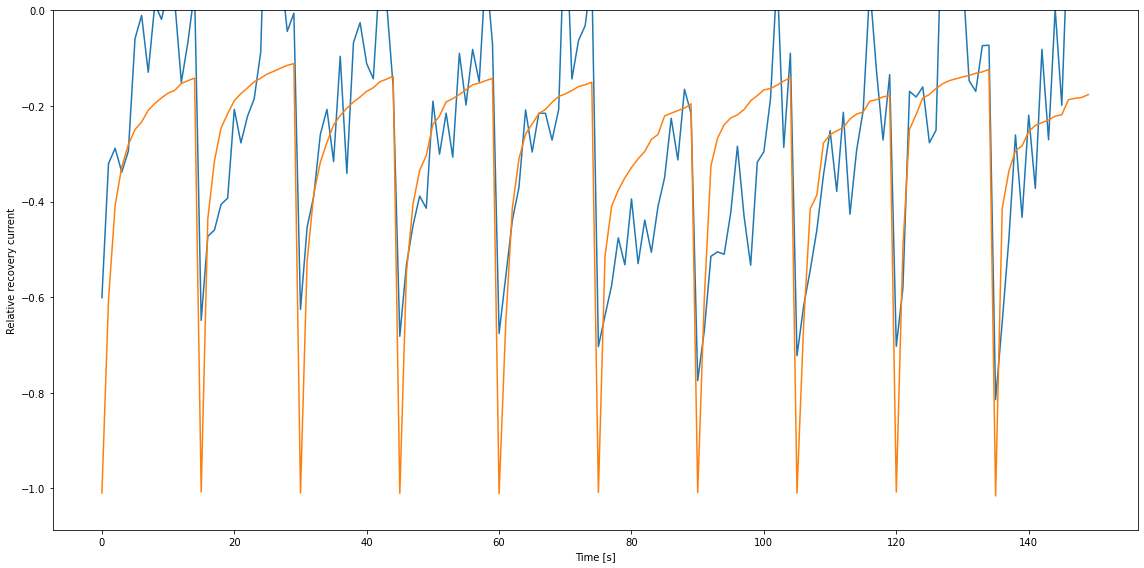

In [77]:
plt.figure(figsize=(16,8))
plt.plot(fit_result["loss_2_rs4"][1])
plt.plot(fit_result["loss_2_rs4"][2])

plt.ylim(top=0.0)
plt.xlabel("Time [s]")
plt.ylabel("Relative recovery current")
plt.tight_layout()